In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline
from torch import Tensor
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def all_scores(labels, preds):
    report = classification_report(labels, preds, digits=3, output_dict=True, zero_division=0)
    acc_sc = balanced_accuracy_score(labels, preds)
    f1_sc = report['macro avg']['f1-score']
    recall_sc = report['macro avg']['recall']
    precision_sc = report['macro avg']['precision']
    return acc_sc, f1_sc, recall_sc, precision_sc

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def auc_roc_sc(labels, probs):
    pred_soft = [softmax(x) for x in probs]
    return roc_auc_score(labels, pred_soft, average='macro', multi_class='ovr')

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/fer_ckplus.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_test.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_train.zip'

In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
len(test_raf_ds)

3068

In [ ]:
valid_size = 700

data_transforms = {
    'train': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(30),
                        tt.ToTensor()]),
    'val': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.ToTensor()]),
}

train_data = ConcatDataset([ImageFolder('/content/rafdb_train', data_transforms['train']),
                            ImageFolder('/content/fer_ckplus', data_transforms['train'])])
val_data = ConcatDataset([ImageFolder('/content/rafdb_train', data_transforms['val']),
                            ImageFolder('/content/fer_ckplus', data_transforms['val'])])

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_data)),
    train_data.datasets[0].targets + train_data.datasets[1].targets,
    stratify=train_data.datasets[0].targets + train_data.datasets[1].targets,
    test_size=valid_size,
)

train_split = Subset(train_data, train_indices)
val_split = Subset(val_data, val_indices)
image_datasets = {
    'train': train_split,
    'val': val_split
    }

batch_size = 64
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=2)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
len(train_indices)

43805

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.input = conv_block(in_channels, 64)

        self.conv1 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)

        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)

        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(nn.MaxPool2d(6),
                                        nn.Flatten(),
                                        nn.Linear(64, num_classes))

    def forward(self, xb):
        out = self.input(xb)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)

        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        return self.classifier(out)

In [ ]:
# source for training funtion https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
def train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=20, patience=10):
    since = time.time()
    results = {'acc': [], 'f1': [], 'rec': [], 'prec': [], 'roc': [], 'val_loss': [], 'train_loss': [], 'lr': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        early_stopping = EarlyStopping(patience=patience, verbose=False)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    pred_list = []
                    label_list = []
                    output_list = []

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=phase):
                    if phase == 'val':
                        label_list = label_list + labels.tolist()

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'val':
                            output_list = output_list + outputs.tolist()
                            pred_list = pred_list + preds.tolist()

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            if grad_clip:
                                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    train_loss = running_loss / dataset_sizes[phase]
                if phase == 'val':
                    val_loss = running_loss / dataset_sizes[phase]
                    acc, f1, prec, rec = all_scores(label_list, pred_list)
                    roc = auc_roc_sc(label_list, output_list)

                    results['acc'].append(acc)
                    results['f1'].append(f1)
                    results['prec'].append(prec)
                    results['rec'].append(rec)
                    results['roc'].append(roc)
                    results['val_loss'].append(val_loss)
                    results['train_loss'].append(train_loss)
                    results['lr'].append(get_lr(optimizer))

                    if epoch < 10:
                        s = '0'
                    else:
                        s = ''

                    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                        s+str(epoch), get_lr(optimizer), train_loss, val_loss, acc))

                # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), best_model_params_path)

                    early_stopping(val_loss, model)

                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [ ]:
model = ResNet(1,7)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
max_lr = 0.001
epochs = 70
grad_clip = 0.2
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(dataloaders['train']))

In [ ]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]          18,464
       BatchNorm2d-9           [-1, 32, 32, 32]              64
             ReLU-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
          Dropout-14           [-1, 64,

In [ ]:
model, results =  train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=epochs, patience=4)

train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [00], last_lr: 0.00005, train_loss: 2.2233, val_loss: 1.8135, val_acc: 0.1428


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [01], last_lr: 0.00006, train_loss: 1.8038, val_loss: 1.8001, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [02], last_lr: 0.00009, train_loss: 1.7625, val_loss: 1.7868, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [03], last_lr: 0.00012, train_loss: 1.7109, val_loss: 1.7821, val_acc: 0.1441


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [04], last_lr: 0.00017, train_loss: 1.6189, val_loss: 1.6451, val_acc: 0.2465


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [05], last_lr: 0.00022, train_loss: 1.4975, val_loss: 1.5144, val_acc: 0.3619


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [06], last_lr: 0.00028, train_loss: 1.3908, val_loss: 1.4156, val_acc: 0.3544


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [07], last_lr: 0.00034, train_loss: 1.3054, val_loss: 1.3977, val_acc: 0.3362


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [08], last_lr: 0.00041, train_loss: 1.2465, val_loss: 1.3039, val_acc: 0.3887


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [09], last_lr: 0.00048, train_loss: 1.1879, val_loss: 1.1858, val_acc: 0.4420


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00056, train_loss: 1.1456, val_loss: 1.2136, val_acc: 0.4357


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00063, train_loss: 1.1113, val_loss: 1.2092, val_acc: 0.4200


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00070, train_loss: 1.0879, val_loss: 1.1580, val_acc: 0.4531


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00076, train_loss: 1.0614, val_loss: 1.1408, val_acc: 0.4516


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00082, train_loss: 1.0398, val_loss: 1.1625, val_acc: 0.4734
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00087, train_loss: 1.0229, val_loss: 1.1193, val_acc: 0.5539


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00092, train_loss: 1.0039, val_loss: 1.0683, val_acc: 0.5062


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00095, train_loss: 0.9936, val_loss: 1.0505, val_acc: 0.5331


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00098, train_loss: 0.9767, val_loss: 1.0779, val_acc: 0.5445


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00099, train_loss: 0.9617, val_loss: 1.0212, val_acc: 0.5322


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00100, train_loss: 0.9532, val_loss: 0.9992, val_acc: 0.5367


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00100, train_loss: 0.9327, val_loss: 1.0310, val_acc: 0.5546


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00100, train_loss: 0.9233, val_loss: 1.0109, val_acc: 0.5789


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00099, train_loss: 0.9130, val_loss: 0.9947, val_acc: 0.5710


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00098, train_loss: 0.9059, val_loss: 0.9968, val_acc: 0.5415


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00097, train_loss: 0.8924, val_loss: 0.9772, val_acc: 0.5331


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00096, train_loss: 0.8882, val_loss: 1.0146, val_acc: 0.5536


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00095, train_loss: 0.8842, val_loss: 0.9898, val_acc: 0.5602


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00094, train_loss: 0.8679, val_loss: 0.9784, val_acc: 0.5635


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00092, train_loss: 0.8598, val_loss: 0.9279, val_acc: 0.5808


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00090, train_loss: 0.8594, val_loss: 0.9694, val_acc: 0.5671


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00088, train_loss: 0.8488, val_loss: 0.9342, val_acc: 0.5817
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00086, train_loss: 0.8416, val_loss: 0.9233, val_acc: 0.5673


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00084, train_loss: 0.8385, val_loss: 0.9369, val_acc: 0.5672


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00081, train_loss: 0.8308, val_loss: 0.9544, val_acc: 0.5749


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00079, train_loss: 0.8247, val_loss: 0.8980, val_acc: 0.5919


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00076, train_loss: 0.8199, val_loss: 0.8876, val_acc: 0.6038


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00073, train_loss: 0.8118, val_loss: 0.9077, val_acc: 0.6068
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00070, train_loss: 0.8066, val_loss: 0.8829, val_acc: 0.5915


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00067, train_loss: 0.7986, val_loss: 0.8796, val_acc: 0.6051


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00064, train_loss: 0.7969, val_loss: 0.8854, val_acc: 0.5774


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41], last_lr: 0.00061, train_loss: 0.7910, val_loss: 0.8790, val_acc: 0.6268


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42], last_lr: 0.00058, train_loss: 0.7874, val_loss: 0.8720, val_acc: 0.6092


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43], last_lr: 0.00055, train_loss: 0.7764, val_loss: 0.8840, val_acc: 0.6025


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44], last_lr: 0.00052, train_loss: 0.7722, val_loss: 0.8304, val_acc: 0.6259


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45], last_lr: 0.00048, train_loss: 0.7647, val_loss: 0.8620, val_acc: 0.6019


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46], last_lr: 0.00045, train_loss: 0.7628, val_loss: 0.8607, val_acc: 0.6113


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47], last_lr: 0.00042, train_loss: 0.7533, val_loss: 0.8766, val_acc: 0.6044


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48], last_lr: 0.00039, train_loss: 0.7496, val_loss: 0.8558, val_acc: 0.6076


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49], last_lr: 0.00036, train_loss: 0.7416, val_loss: 0.8504, val_acc: 0.6389


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50], last_lr: 0.00033, train_loss: 0.7369, val_loss: 0.8371, val_acc: 0.6067


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51], last_lr: 0.00030, train_loss: 0.7308, val_loss: 0.8195, val_acc: 0.6350


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52], last_lr: 0.00027, train_loss: 0.7288, val_loss: 0.8325, val_acc: 0.6274


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53], last_lr: 0.00024, train_loss: 0.7199, val_loss: 0.8233, val_acc: 0.6517


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54], last_lr: 0.00021, train_loss: 0.7183, val_loss: 0.8289, val_acc: 0.6494


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55], last_lr: 0.00019, train_loss: 0.7116, val_loss: 0.8072, val_acc: 0.6469


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56], last_lr: 0.00016, train_loss: 0.7101, val_loss: 0.8268, val_acc: 0.6387


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57], last_lr: 0.00014, train_loss: 0.7024, val_loss: 0.7968, val_acc: 0.6662


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58], last_lr: 0.00012, train_loss: 0.7017, val_loss: 0.8048, val_acc: 0.6474


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59], last_lr: 0.00010, train_loss: 0.6995, val_loss: 0.8160, val_acc: 0.6428


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60], last_lr: 0.00008, train_loss: 0.6930, val_loss: 0.8007, val_acc: 0.6346


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61], last_lr: 0.00006, train_loss: 0.6907, val_loss: 0.7991, val_acc: 0.6472


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [62], last_lr: 0.00005, train_loss: 0.6895, val_loss: 0.8085, val_acc: 0.6452


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63], last_lr: 0.00004, train_loss: 0.6879, val_loss: 0.7933, val_acc: 0.6630


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64], last_lr: 0.00003, train_loss: 0.6814, val_loss: 0.7897, val_acc: 0.6561


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65], last_lr: 0.00002, train_loss: 0.6798, val_loss: 0.7865, val_acc: 0.6626


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66], last_lr: 0.00001, train_loss: 0.6800, val_loss: 0.8008, val_acc: 0.6576


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67], last_lr: 0.00000, train_loss: 0.6815, val_loss: 0.7942, val_acc: 0.6412


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68], last_lr: 0.00000, train_loss: 0.6798, val_loss: 0.7888, val_acc: 0.6543


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69], last_lr: 0.00000, train_loss: 0.6778, val_loss: 0.8069, val_acc: 0.6555
Training complete in 63m 55s
Best val Acc: 0.666187


In [ ]:
kdef_ds = ImageFolder('/content/kdef', data_transforms['val'])
kdef_test_dl = DataLoader(kdef_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.6633 , roc: 0.957 , f1: 0.6295 , recall: 0.7803


In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(test_raf_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/48 [00:00<?, ?it/s]

acc: 0.7016 , roc: 0.9601 , f1: 0.7066 , recall: 0.7198


In [ ]:
# acc: 0.663265306122449 , roc: 0.9513459669582119 , f1: 0.6452388586723082 (ep: 60 lr: 0.001 gc 0.1)

In [ ]:
# acc: 0.6918367346938775 , roc: 0.9473372206025267 , f1: 0.6508315059070727 (ep: 40 lr: 0,001 gc 0.2)

In [ ]:
# acc: 0.710204081632653 , roc: 0.9571817298347911 , f1: 0.6888354804934647 (ep: 40 lr: 0,001 gc 0.2)

In [ ]:
print(results)

{'acc': [0.14277662755923623, 0.14285714285714285, 0.14285714285714285, 0.1440677966101695, 0.24646371789467633, 0.3618909031282304, 0.35437772309009674, 0.3362491470513245, 0.38871973020726747, 0.4420424942786348, 0.4357019133680447, 0.42001555784083683, 0.4530586855761844, 0.4516479346991705, 0.47344588565178786, 0.553876459812401, 0.5062340796375645, 0.5331017069022855, 0.5444782040446229, 0.5322045357475479, 0.5367118547549772, 0.5545769457763232, 0.5789470445588724, 0.5710212277981915, 0.5414737181098989, 0.533112309111167, 0.553587831286691, 0.560153720646329, 0.5634926592367074, 0.5807514406915429, 0.5671099393975659, 0.5817469798073737, 0.5672521859410796, 0.5671580337089085, 0.574876635498612, 0.5919333613506292, 0.6037944992008468, 0.6068407305101785, 0.5915388956828279, 0.6050705698006499, 0.5773647109050181, 0.6267990974012027, 0.6092360740623023, 0.6025291704635742, 0.6259125825814651, 0.6018746961670489, 0.611253852037029, 0.6043973050308394, 0.6075795443432378, 0.6389412

In [ ]:
results = {'acc': [0.14277662755923623, 0.14285714285714285, 0.14285714285714285, 0.1440677966101695, 0.24646371789467633, 0.3618909031282304, 0.35437772309009674, 0.3362491470513245, 0.38871973020726747, 0.4420424942786348, 0.4357019133680447, 0.42001555784083683, 0.4530586855761844, 0.4516479346991705, 0.47344588565178786, 0.553876459812401, 0.5062340796375645, 0.5331017069022855, 0.5444782040446229, 0.5322045357475479, 0.5367118547549772, 0.5545769457763232, 0.5789470445588724, 0.5710212277981915, 0.5414737181098989, 0.533112309111167, 0.553587831286691, 0.560153720646329, 0.5634926592367074, 0.5807514406915429, 0.5671099393975659, 0.5817469798073737, 0.5672521859410796, 0.5671580337089085, 0.574876635498612, 0.5919333613506292, 0.6037944992008468, 0.6068407305101785, 0.5915388956828279, 0.6050705698006499, 0.5773647109050181, 0.6267990974012027, 0.6092360740623023, 0.6025291704635742, 0.6259125825814651, 0.6018746961670489, 0.611253852037029, 0.6043973050308394, 0.6075795443432378, 0.6389412354561875, 0.6067398913182472, 0.6349951684728578, 0.6274187082575092, 0.6517336550156533, 0.6494272997379326, 0.6468820094063114, 0.6387337758400685, 0.6661867290126117, 0.6474386985774141, 0.6428419931944634, 0.6345798847966341, 0.6471764604930925, 0.6451982368292873, 0.6629743893584121, 0.6561434568481885, 0.6625958324589794, 0.6575515843114179, 0.6411666437559193, 0.6542520451689507, 0.6555470193853921], 'f1': [0.06980100258240922, 0.06737367436057393, 0.06737367436057393, 0.06990205272480983, 0.21072175405306254, 0.3438116966475319, 0.3274010662625133, 0.31207773278863077, 0.37544766926195416, 0.4390088215859773, 0.4296294299289639, 0.3981135756370637, 0.44270874479055516, 0.4478178824669597, 0.4550431882669813, 0.5672030631254835, 0.5096320145129074, 0.5450868165978455, 0.5481532728515484, 0.5282343662702603, 0.5433924819656629, 0.5518906494796756, 0.5879203838154358, 0.5876170009440287, 0.5496969806336848, 0.5483329713089026, 0.5635404301093091, 0.561383556199335, 0.5702014856647154, 0.5883114164459354, 0.578878085542034, 0.5933212336545735, 0.5709211157977742, 0.5662025747127072, 0.5758999628965189, 0.605802690112002, 0.6105319991043313, 0.6199615992115409, 0.5978971469539784, 0.6186028302596129, 0.5889673899996783, 0.6397397491533114, 0.6244609722672748, 0.6151562342544727, 0.6458997184193453, 0.6155803311738006, 0.6273946698232257, 0.6174192176969798, 0.6229628700930175, 0.6575103209606132, 0.6230718990344716, 0.6565748169566873, 0.6413605321761805, 0.668734120754639, 0.6640246692564108, 0.6618273015016262, 0.6543190261464751, 0.680935013528926, 0.6646088026962875, 0.663957165695748, 0.6557256983170722, 0.6646061206951696, 0.6624690256899796, 0.6821061997102138, 0.6755460319431121, 0.6874928848031717, 0.6745840432749951, 0.6573694545513786, 0.6701860874115286, 0.6745532245496977], 'rec': [0.1870355078447564, 0.04408163265306122, 0.04408163265306122, 0.11563651248465003, 0.339767422461741, 0.5082757987554791, 0.37244321624449755, 0.48601846913032615, 0.40457134730017785, 0.5375682596270831, 0.4639724504421525, 0.4734377826035646, 0.4896634692060045, 0.6361377841780976, 0.6551074540723832, 0.6009372807519282, 0.6464428628810724, 0.6631436693069689, 0.6706031934304821, 0.6119796311329895, 0.6398680057458072, 0.6359479706346066, 0.6412833136664954, 0.6858419858525746, 0.6635953620067244, 0.6705656758779294, 0.6446074365127723, 0.6429750721074546, 0.6527171073821056, 0.6434389822166134, 0.6995748245296423, 0.648821534545024, 0.6837946994510007, 0.6698598194734559, 0.6313693588589663, 0.6847601611794499, 0.6340003981319223, 0.683978194290943, 0.6635601119181117, 0.7072432781954543, 0.7024029469271637, 0.6808283279967561, 0.7032067211997524, 0.6928286064873104, 0.7273981973441673, 0.6799887484326883, 0.6821481647538251, 0.6867173028737169, 0.6810903814226801, 0.7105974193870656, 0.6797592681526934, 0.7205382348624761, 0.6876799734448922, 0.7063777599491885, 0.693166401172764, 0.7015286939562592, 0.6884355724146188, 0.7177428661815259, 0.7115198711056018, 0.7208748001974771, 0.7218440638651613, 0.7084516586697401, 0.7122054877773197, 0.7204377578620825, 0.7354012579023549, 0.7493549290571674, 0.7166866223092873, 0.6997638575257884, 0.7140240347840443, 0.7171177053013363], 'prec': [0.14277662755923623, 0.14285714285714285, 0.14285714285714285, 0.1440677966101695, 0.24646371789467633, 0.3618909031282304, 0.35437772309009674, 0.3362491470513245, 0.38871973020726747, 0.4420424942786348, 0.4357019133680447, 0.42001555784083683, 0.4530586855761844, 0.4516479346991705, 0.47344588565178786, 0.553876459812401, 0.5062340796375645, 0.5331017069022855, 0.5444782040446229, 0.5322045357475479, 0.5367118547549772, 0.5545769457763232, 0.5789470445588724, 0.5710212277981915, 0.5414737181098989, 0.533112309111167, 0.553587831286691, 0.560153720646329, 0.5634926592367074, 0.5807514406915429, 0.5671099393975659, 0.5817469798073737, 0.5672521859410796, 0.5671580337089085, 0.574876635498612, 0.5919333613506292, 0.6037944992008468, 0.6068407305101785, 0.5915388956828279, 0.6050705698006499, 0.5773647109050181, 0.6267990974012027, 0.6092360740623023, 0.6025291704635742, 0.6259125825814651, 0.6018746961670489, 0.611253852037029, 0.6043973050308394, 0.6075795443432378, 0.6389412354561875, 0.6067398913182472, 0.6349951684728578, 0.6274187082575092, 0.6517336550156533, 0.6494272997379326, 0.6468820094063114, 0.6387337758400685, 0.6661867290126117, 0.6474386985774141, 0.6428419931944634, 0.6345798847966341, 0.6471764604930925, 0.6451982368292873, 0.6629743893584121, 0.6561434568481885, 0.6625958324589794, 0.6575515843114179, 0.6411666437559193, 0.6542520451689507, 0.6555470193853921], 'roc': [0.5704006640722837, 0.5692553215693926, 0.5838514530115323, 0.6221869448675706, 0.734256439792976, 0.7865288970507459, 0.8070150845272445, 0.8283849289342488, 0.8451405042739523, 0.8721116236829539, 0.8723546862338776, 0.8692271490642841, 0.8757879520550491, 0.8831656265420641, 0.8858692429793288, 0.8940528439401138, 0.8976125629085286, 0.9040875427679439, 0.8935612163967834, 0.9076529990296835, 0.9141950717021924, 0.9063166119176485, 0.9095328728133786, 0.9065801038332488, 0.9127442465031563, 0.9135566746504743, 0.9121650092815617, 0.9152294142454902, 0.9170639654690802, 0.9240277267454277, 0.9181255136597197, 0.9225002019955805, 0.9249503590734596, 0.9242890183366766, 0.92107541379438, 0.9305048323946105, 0.9289001180718898, 0.9292490401733672, 0.9314298268190692, 0.9314492430669186, 0.9265136712102101, 0.9317515758523653, 0.9339516554583077, 0.9331782152100302, 0.9376602403255581, 0.9307479584902529, 0.9331480600390035, 0.9324663140052065, 0.9328256696227974, 0.9389492038938431, 0.9377170780714594, 0.9410629228524426, 0.9398350741687441, 0.9361110279355546, 0.938991638260754, 0.9432613211438058, 0.938457649176592, 0.9451590325756888, 0.9393317406442387, 0.9412431019392293, 0.9418709758927007, 0.9415380707655921, 0.9381769734534622, 0.9412790697884927, 0.9419293487664433, 0.9436609778427629, 0.9393312639845206, 0.9413830133594685, 0.9438821036989978, 0.9390440366612272], 'val_loss': [1.8134697314671109, 1.8000633655275617, 1.7868090541022164, 1.7820898478371756, 1.6451260137557984, 1.5144106640134538, 1.4155750029427665, 1.3977002804619925, 1.30385473046984, 1.1858142382758003, 1.2135542011260987, 1.2091824054718017, 1.1580024855477469, 1.140845788546971, 1.1624806918416704, 1.1193435369219098, 1.0683406693594797, 1.0504511513028827, 1.0778742149897984, 1.021217419079372, 0.9991890512193953, 1.030994908469064, 1.0108586471421377, 0.9946871450969151, 0.9968187155042376, 0.9771763804980687, 1.0146155820574079, 0.9898476702826363, 0.9783975376401629, 0.9278916192054748, 0.9694457599094936, 0.9341756013461522, 0.9232633127485003, 0.9369322620119367, 0.9544428471156529, 0.8979998115130833, 0.8875662176949637, 0.9076726164136614, 0.8828650525638035, 0.8795560039792742, 0.8853668488774981, 0.879036386013031, 0.8720204727990287, 0.8839864584377833, 0.8304327065604074, 0.8620008676392692, 0.8606751210348946, 0.8765931756155831, 0.8557548941884722, 0.8504104535920279, 0.8371187084061759, 0.8195103345598493, 0.8324568142209734, 0.8233169099262783, 0.8289008777482169, 0.8072377579552786, 0.8267962193489075, 0.7967961696216038, 0.8047769287654332, 0.8159664000783647, 0.8006927694593157, 0.7990567146028791, 0.808530787399837, 0.7932798896517073, 0.7896612858772278, 0.7865255400112697, 0.8007551295416696, 0.7941694974899292, 0.7888101843425206, 0.8068835077966963], 'train_loss': [2.223316007130713, 1.8037687946326546, 1.7624736640703975, 1.7109260868256038, 1.6189488334044, 1.4975366203415654, 1.3907794706381398, 1.3053765396156916, 1.2465162254607156, 1.187929262726863, 1.1456009810080527, 1.1112666783029665, 1.0879384607773994, 1.0614106993277368, 1.039760199222863, 1.0228791449728818, 1.0038771409120832, 0.9935920868898523, 0.9766732319048205, 0.9617186694531091, 0.9531720046950263, 0.9326578376717987, 0.9233415137658774, 0.9130380000497718, 0.9058623517924365, 0.8923559008375611, 0.8881999478507785, 0.8841994449028535, 0.8678932866880358, 0.8598047134062836, 0.859367659558391, 0.8487658188326992, 0.841565818007495, 0.8385209281005593, 0.8308045003229374, 0.8246599271653681, 0.819893770752099, 0.8118181040128907, 0.8066003825624788, 0.7986443285800022, 0.7969042054010219, 0.7909787249053508, 0.7874200936825686, 0.7763918923537028, 0.7722069520817515, 0.7646662060575743, 0.7627965734737293, 0.7532931983069516, 0.7495735633211339, 0.7415927583571779, 0.7369066620986084, 0.7308155977110955, 0.7287705071167564, 0.7198770424421894, 0.7183138004395396, 0.7116121150290445, 0.7101415424311002, 0.7023774963224768, 0.7016979249654982, 0.6994958459534965, 0.6930059482430557, 0.6907489785632646, 0.6895232027958904, 0.6878811881158766, 0.6814133611257157, 0.67976746163593, 0.6800361298015299, 0.6815198157002645, 0.6797659825644609, 0.6778159941076864], 'lr': [4.5361947486692675e-05, 6.132799627656235e-05, 8.754144172302037e-05, 0.0001234166375013616, 0.0001681520797955934, 0.00022074831405415063, 0.000280030264251649, 0.00034467348578863977, 0.00041323375550157324, 0.0004841793376993065, 0.000555925205356185, 0.0006268684519106947, 0.0006954241025188323, 0.0007600605246869442, 0.0008193336471592257, 0.0008719192225603906, 0.0009166424129993617, 0.000952504037648759, 0.0009787028958912597, 0.0009946536673014154, 0.0009999999978098962, 0.0009989696999116644, 0.0009958890367062594, 0.000990770667299593, 0.0009836356241694432, 0.0009745132267384943, 0.0009634409608945379, 0.0009504643249529205, 0.0009356366426942059, 0.0009190188442453229, 0.0009006792157046046, 0.000880693118539563, 0.0008591426799104535, 0.0008361164551921577, 0.0008117090640811526, 0.0007860208017828827, 0.0007591572268772463, 0.0007312287275557493, 0.0007023500680127483, 0.0006726399168547585, 0.0006422203594656955, 0.0006112163963318454, 0.0005797554293880546, 0.0005479667384958514, 0.0005159809502047645, 0.00048392950097981224, 0.000451944097100874, 0.0004201561734533363, 0.00038869635343395485, 0.00035769391219129957, 0.0003272762454064393, 0.00029756834579676216, 0.00026869228949408903, 0.00024076673440766172, 0.00021390643263334336, 0.0001882217589126416, 0.00016381825707921974, 0.00014079620635664585, 0.00011925020928955364, 9.92688030014937e-05, 8.093409537690189e-05, 6.432142766219004e-05, 4.9499064872403824e-05, 3.652791527563348e-05, 2.5461280107875014e-05, 1.6344634546818422e-05, 9.21544084458853e-06, 4.1029943873149815e-06, 1.0283033141070992e-06, 4.002190103886344e-09]}


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/msc_thesis/notebooks/resnetnewraf.pt')

In [ ]:
criterion = nn.CrossEntropyLoss()
model = ResNet(1,7)
model.load_state_dict(torch.load('/content/drive/MyDrive/msc_thesis/notebooks/resnetnewraf.pt'))
model = model.to(device)

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef_faces.zip'
criterion = nn.CrossEntropyLoss()
kdef_f_ds = ImageFolder('/content/kdef_faces', data_transforms['val'])
kdef_f_test_dl = DataLoader(kdef_f_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_f_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.7286 , roc: 0.9623 , f1: 0.717 , recall: 0.7853


In [ ]:
def plot_scores(results):
    plt.figure(figsize=(8, 6), dpi=150)
    epochs = len(results['acc'])
    # plt.plot(results['prec'], color='limegreen', label='precision')
    plt.plot(results['rec'], color='orange', label='recall')
    plt.plot(results['f1'], color='dodgerblue', label='f1-score')
    plt.plot(results['roc'], color = 'blueviolet', label='roc-auc')
    plt.plot(results['acc'], color='red', label='accuracy')
    plt.ylabel('performance scores')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title('Model performance vs. No. of epochs')
    plt.show()

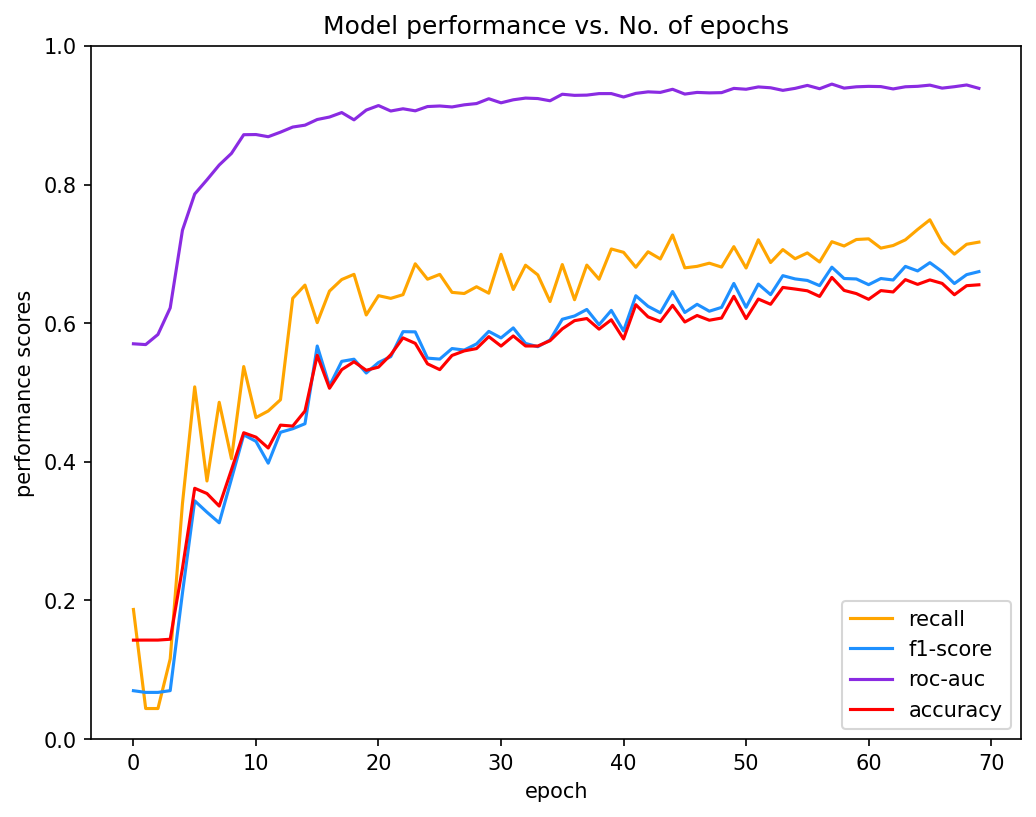

In [ ]:
plot_scores(results)

In [ ]:
def plot_lrs(lrs):
    plt.figure(figsize=(8, 6), dpi=150)
    plt.plot(lrs)
    plt.xlabel('Epoch')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Epoch with RAF-DB')
    plt.xlim(-5,95)

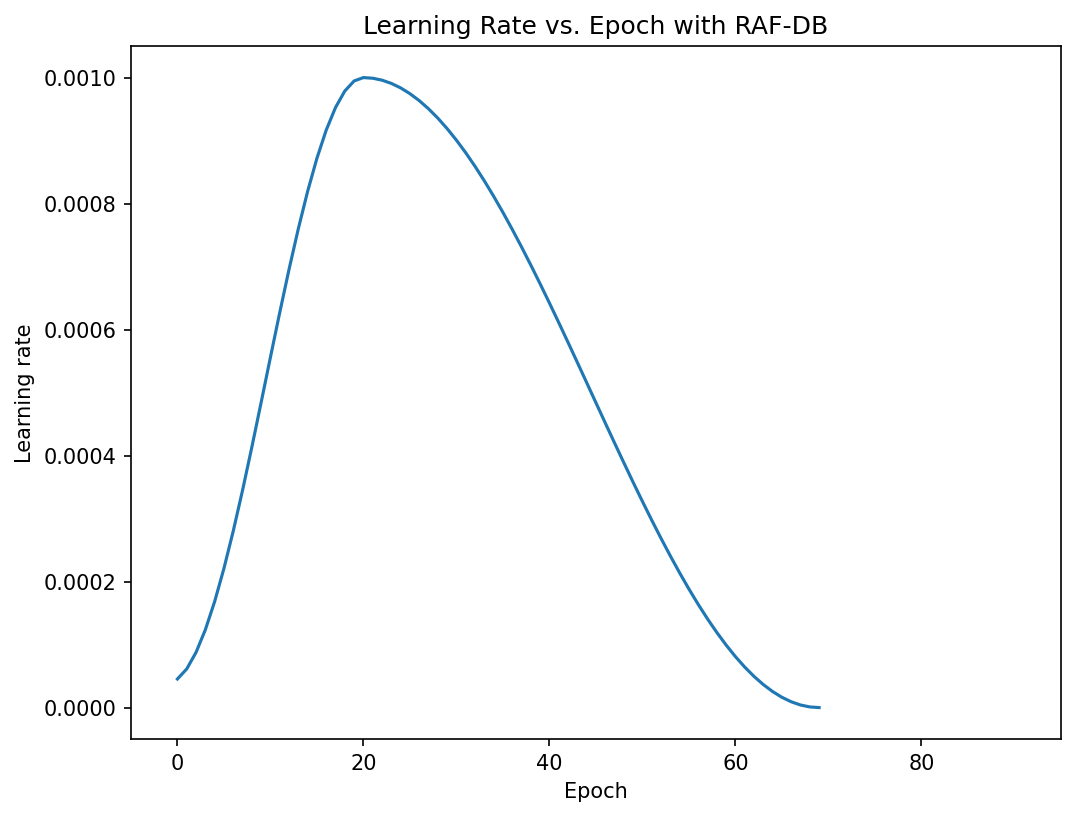

In [ ]:
plot_lrs(results['lr'])

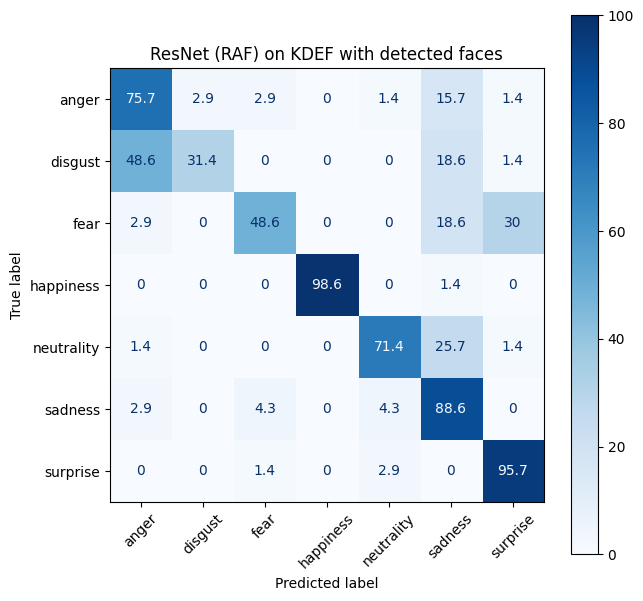

In [ ]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay

confm1 = sklearn.metrics.confusion_matrix(label_list, pred_list, normalize='true')
confm1 = np.round(confm1*100, 1)
classes = ['anger', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']

plt.rcParams["figure.figsize"] = (7,7)

disp = ConfusionMatrixDisplay(confusion_matrix=confm1,
                              display_labels=classes)

disp.plot(cmap=plt.cm.Blues, values_format='.3g')
disp.im_.set_clim(0, 100)
plt.xticks(rotation=45)
plt.title("ResNet (RAF) on KDEF with detected faces")
plt.show()

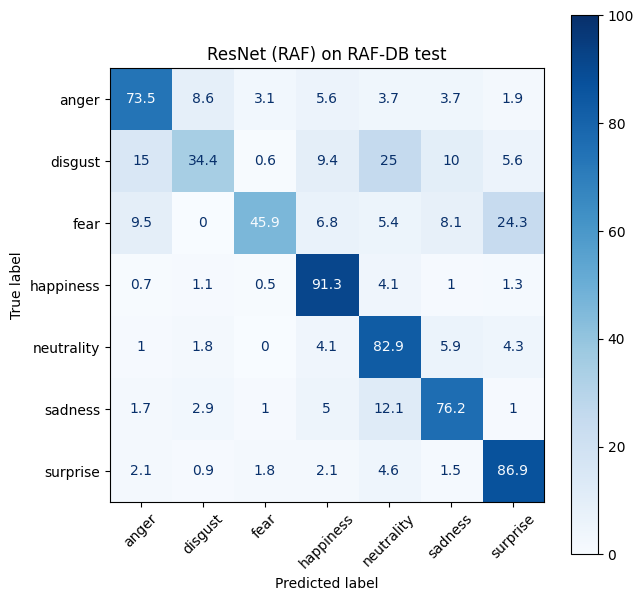

In [ ]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay

confm1 = sklearn.metrics.confusion_matrix(label_list, pred_list, normalize='true')
confm1 = np.round(confm1*100, 1)
classes = ['anger', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']

plt.rcParams["figure.figsize"] = (7,7)

disp = ConfusionMatrixDisplay(confusion_matrix=confm1,
                              display_labels=classes)

disp.plot(cmap=plt.cm.Blues, values_format='.3g')
disp.im_.set_clim(0, 100)
plt.xticks(rotation=45)
plt.title("ResNet (RAF) on RAF-DB test")
plt.show()

In [ ]:
#source for timing the model execution: https://deci.ai/blog/measure-inference-time-deep-neural-networks/
dummy_input = torch.randn(1,1,64,64, dtype=torch.float).to(device)

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 10000
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print("Avg prediction time:", round(mean_syn,3), "Sd:", round(std_syn,3))

Avg prediction time: 2.405 Sd: 1.214
